In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline


In [2]:
def load_images(directory):
    images = []
    for filename in sorted(os.listdir(directory)):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path)
            if img is not None:
                images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    return images

In [3]:
preprocessed_directory = "../data/preprocessed"
preprocessed_images = load_images(preprocessed_directory)
print(f"Loaded {len(preprocessed_images)} preprocessed images.")


Loaded 120 preprocessed images.


In [4]:
def detect_and_match_features(img1, img2):
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY), None)
    kp2, des2 = sift.detectAndCompute(cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY), None)
    
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)
    
    return kp1, kp2, good_matches

In [5]:
kp1, kp2, good_matches = detect_and_match_features(preprocessed_images[0], preprocessed_images[1])


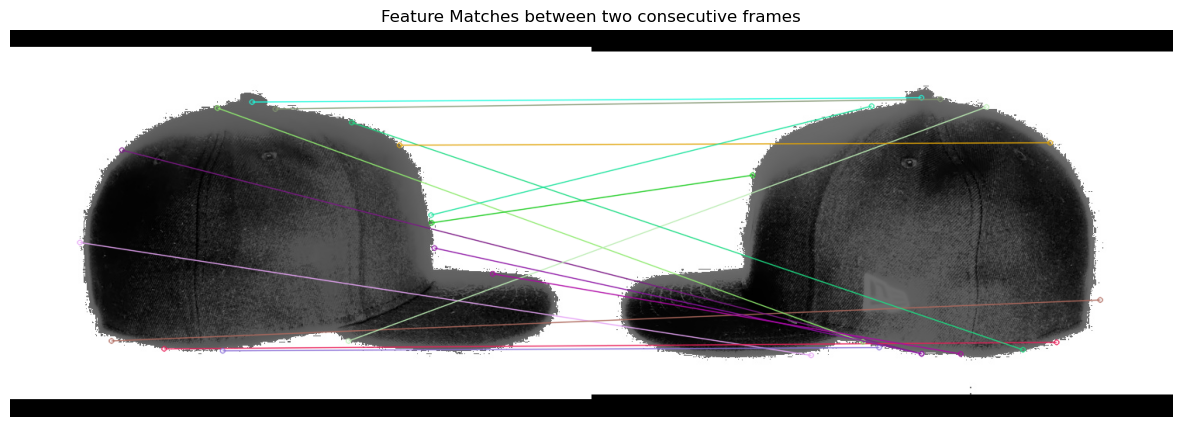

In [6]:
match_img = cv2.drawMatches(preprocessed_images[0], kp1, preprocessed_images[1], kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(15, 10))
plt.imshow(match_img)
plt.title("Feature Matches between two consecutive frames")
plt.axis('off')
plt.show()


In [7]:
def estimate_motion(kp1, kp2, matches):
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    return M

In [8]:
M = estimate_motion(kp1, kp2, good_matches)
print("Estimated Homography Matrix:")
print(M)

Estimated Homography Matrix:
[[-1.51368508e-01  5.74406177e-02  3.54862410e+02]
 [-7.53513119e-01 -6.00605583e-01  6.31144207e+02]
 [ 8.75439997e-05 -1.05918517e-03  1.00000000e+00]]


In [9]:
def stitch_images(images):
    stitcher = cv2.Stitcher_create()
    status, stitched = stitcher.stitch(images)
    
    if status == cv2.Stitcher_OK:
        return stitched
    else:
        print("Stitching failed!")
        return None

In [10]:
stitched_image = stitch_images([cv2.cvtColor(img, cv2.COLOR_RGB2BGR) for img in preprocessed_images])

In [ ]:
if stitched_image is not None:
    plt.figure(figsize=(20, 10))
    plt.imshow(cv2.cvtColor(stitched_image, cv2.COLOR_BGR2RGB))
    plt.title("Stitched 360 Degree View")
    plt.axis('off')
    plt.show()
    
    # Sauvegarder l'image assemblée
    cv2.imwrite("../output/stitched_image.jpg", stitched_image)
    print("Saved stitched image to ../output/stitched_image.jpg")


In [ ]:
def triangulate_points(P1, P2, pts1, pts2):
    pts1 = pts1.reshape(-1, 1, 2)
    pts2 = pts2.reshape(-1, 1, 2)
    
    points_4d = cv2.triangulatePoints(P1, P2, pts1, pts2)
    points_3d = points_4d[:3, :] / points_4d[3, :]
    return points_3d.T


In [ ]:
K = np.array([[1000, 0, 500], [0, 1000, 500], [0, 0, 1]])  # Approximate camera matrix
R1 = np.eye(3)
t1 = np.zeros((3, 1))
P1 = K @ np.hstack((R1, t1))


In [ ]:
R2, _ = cv2.Rodrigues(M[:3, :3])
t2 = M[:3, 3].reshape(3, 1)
P2 = K @ np.hstack((R2, t2))


In [ ]:
pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])


In [ ]:
points_3d = triangulate_points(P1, P2, pts1, pts2)


In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], c='b', marker='.')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Reconstruction of Points')
plt.show()



In [ ]:
np.save("../output/reconstructed_points.npy", points_3d)
np.save("../output/camera_matrices.npy", np.array([P1, P2]))
print("Saved reconstruction data to ../output/")